### Your name:

<pre> Zahir Mohammed Mandsaurwala</pre>

### Collaborators:

<pre> None</pre>

## Assignment for Module 4, Training Models

In this assignment you will train different models on a given data set, and find the one that performs best

### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [1]:
# Common imports
import numpy as np
import os
import tarfile
from six.moves import urllib
import pandas as pd

#hide warnings
import warnings
warnings.filterwarnings("ignore")

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import root_mean_squared_error, mean_squared_error

from sklearn.pipeline import Pipeline

np.random.seed(42)

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    print(f"Loading data from: {housing_url}" )
    print(f"Saving data to:    {housing_path}" )
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

Loading data from: https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz
Saving data to:    datasets\housing


In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [6]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [7]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [8]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [9]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20640 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   rooms_per_household       20640 non-null  float64
 10  population_per_household  20640 non-null  float64
 11  INLAND                    20640 non-null  bool   
 12  ISLAND                    20640 non-null  bool   
 13  LESS_1H_OCEAN             20640 non-null  bool   
 14  NEAR_B

# ASSIGNMENT

### 1. Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.

In [11]:
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

### Features

In [12]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [13]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

# This is for usage during the pipeline
X_tr_pipeline = X_tr
X_te_pipeline = X_te

### 2. Polynomial transformations

Use PolynomialFeatures from sklearn.preprocessing

In [14]:
poly = PolynomialFeatures(2)
poly.fit(X_tr)
X_tr = poly.transform(X_tr)
X_te = poly.transform(X_te)

##### You should obtain X_tr and X_te with 136 columns each, since originally you had 15 features.

##### With m original features, the new added polynomial features of degree 2 are: $(m^2-m)/2+m+1$. Why?

##### These, plus the original features gives a total of  $(m^2-m)/2+2m+1$

##### The new added polynomial feature of degree 2 = (15 + 2)! / (15! 2!) = 136

In [15]:
print("Original number of features: "+str(len(features)))
print("Final number of features: "+str(X_tr.shape[1]))

Original number of features: 15
Final number of features: 136


### 3. Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [16]:
std_scaler = StandardScaler()

X_tr_scaled  = std_scaler.fit_transform(X_tr)
X_te_scaled = std_scaler.transform(X_te) # Only transform as its a test data

print("Original number of features: "+str(len(features)))
print("Final number of features: "+str(X_tr_scaled.shape[1]))

Original number of features: 15
Final number of features: 136


#### Comparing models

In [17]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### 4. Linear regression on original features (no transformations) --- benchmark

#### Your goal is to find the model that minimizes the rmse score

In [18]:
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [70142.55721218 67456.39127204 67318.3258893  70866.26065275]
Mean: 68945.88375656873


### 5. Linear regression  (on transformed features: polynomial transformation + scaling)

Now do as in 4 but with the original and transformed features (136 features)

In [19]:
lin_scores_poly_scaled = cross_val_score(LinearRegression(), X_tr_scaled, y_tr, scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores_poly_scaled = np.sqrt(-lin_scores_poly_scaled)
display_scores(lin_rmse_scores_poly_scaled)

Scores: [4.74115143e+13 3.80197508e+14 1.20977671e+12 7.23416732e+13]
Mean: 125290118035842.78


If the error on the cross-validation is too high it is because the model is over-fitting. Regularization is needed.

### 6. Ridge regression

In [20]:
param_grid_rr = [{'alpha': [0.001,0.01,0.1,1,10,100,1000]}] # removing duplicate 1000
grid_search_rr = GridSearchCV(Ridge(), param_grid_rr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1) # n_jobs has been added to utilize all cores
grid_search_rr.fit(X_tr_scaled, y_tr)

GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             scoring='neg_mean_squared_error')

In [21]:
print(grid_search_rr.best_params_)
print(np.sqrt(-grid_search_rr.best_score_))

{'alpha': 1000}
67204.15300429484


In [22]:
rr_scores = cross_val_score(Ridge(), X_tr_scaled, y_tr, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)
rr_rmse_scores = np.sqrt(-rr_scores)
print("Cross-Validation RMSE Scores:", rr_rmse_scores)
print("Mean RMSE:", rr_rmse_scores.mean())
print("Standard Deviation:", rr_rmse_scores.std())

Cross-Validation RMSE Scores: [ 80934.74813087 195539.54110527 101943.89790481]
Mean RMSE: 126139.39571364845
Standard Deviation: 49817.20739422719


### 7. Lasso regression

Now do the same as in 6 but with Lasso

In [23]:
param_grid_lr = [{'alpha': [0.001,0.01,0.1,1,10,100,1000]}] # removing duplicate 1000
grid_search_lr = GridSearchCV(Lasso(), param_grid_lr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1) # n_jobs has been added to utilize all cores
grid_search_lr.fit(X_tr_scaled, y_tr)

GridSearchCV(cv=3, estimator=Lasso(), n_jobs=-1,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             scoring='neg_mean_squared_error')

In [24]:
print(grid_search_lr.best_params_)
print(np.sqrt(-grid_search_lr.best_score_))

{'alpha': 1000}
66619.6312718291


In [25]:
lr_scores = cross_val_score(Lasso(), X_tr_scaled, y_tr, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)
lr_rmse_scores = np.sqrt(-lr_scores)
print("Cross-Validation RMSE Scores:", lr_rmse_scores)
print("Mean RMSE:", lr_rmse_scores.mean())
print("Standard Deviation:", lr_rmse_scores.std())

Cross-Validation RMSE Scores: [ 64091.16318497 128149.10961912  90794.28196516]
Mean RMSE: 94344.85158974667
Standard Deviation: 26271.785040667262


### 8. Elastic Net regression

Do the same as in 6 and 7, but now with Elastic Net. However, the grid search should be over the parameters alpha and  l 1ratio. Use just 3 values for l1_ratio.

#### Choosing the best values of L1_ratio and alpha

In [26]:
param_grid_choose_l1_enr = [{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search_choose_l1_enr = GridSearchCV(ElasticNet(), param_grid_choose_l1_enr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_choose_l1_enr.fit(X_tr_scaled, y_tr)

print("Best l1_ratio:", grid_search_choose_l1_enr.best_params_['l1_ratio'])
print("Best alpha:", grid_search_choose_l1_enr.best_params_['alpha'])

Best l1_ratio: 0.4
Best alpha: 0.1


#### As the best value of l1_ratio is 0.4, hence choosing the 3 values around 0.4

In [27]:
param_grid_enr = [{'alpha': [0.1], 'l1_ratio': [0.35, 0.4, 0.45]}]

grid_search_enr = GridSearchCV(ElasticNet(), param_grid_enr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_enr.fit(X_tr_scaled, y_tr)

GridSearchCV(cv=3, estimator=ElasticNet(), n_jobs=-1,
             param_grid=[{'alpha': [0.1], 'l1_ratio': [0.35, 0.4, 0.45]}],
             scoring='neg_mean_squared_error')

In [28]:
print(grid_search_enr.best_params_)
print(np.sqrt(-grid_search_enr.best_score_))

{'alpha': 0.1, 'l1_ratio': 0.4}
67072.67698457319


#### Getting cross validation scores

In [29]:
elastic_net_scores = cross_val_score(ElasticNet(alpha=0.1, l1_ratio=0.4), X_tr_scaled, y_tr, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)
elastic_net_rmse_scores = np.sqrt(-elastic_net_scores)
print("Cross-Validation RMSE Scores:", elastic_net_rmse_scores)
print("Mean RMSE:", elastic_net_rmse_scores.mean())
print("Standard Deviation:", elastic_net_rmse_scores.std())

Cross-Validation RMSE Scores: [65520.39991593 68268.77514196 67399.4327061 ]
Mean RMSE: 67062.86925466261
Standard Deviation: 1146.9809104432975


### Analyzing Elastic Net's features

In [30]:
best_estimator_enr = grid_search_enr.best_estimator_
coef_enr = best_estimator_enr.coef_

num_selected_features_enr = np.sum(coef_enr != 0)
num_total_features_enr = len(coef_enr)
num_dropped_features_enr = num_total_features_enr - num_selected_features_enr

print(f"Total Features: {num_total_features_enr}")
print(f"Selected Features: {num_selected_features_enr}")
print(f"Dropped Features: {num_dropped_features_enr}")

poly_feature_names = poly.get_feature_names_out(features)
dropped_features_enr = [poly_feature_names[i] for i in range(len(poly_feature_names)) if coef_enr[i] == 0]

print("Dropped Features:", dropped_features_enr)

Total Features: 136
Selected Features: 125
Dropped Features: 11
Dropped Features: ['1', 'INLAND ISLAND', 'INLAND LESS_1H_OCEAN', 'INLAND NEAR_BAY', 'INLAND NEAR_OCEAN', 'ISLAND LESS_1H_OCEAN', 'ISLAND NEAR_BAY', 'ISLAND NEAR_OCEAN', 'LESS_1H_OCEAN NEAR_BAY', 'LESS_1H_OCEAN NEAR_OCEAN', 'NEAR_BAY NEAR_OCEAN']


### Evaluating your best model on TESTING data

Choose among grid_search_rr, grid_search_lr, and grid_search_enr, the model with best performance

##### Elastic Net Regression turns out to be the best because it has both low Mean RMSE (= 67062.86925466261) as well as low standard deviation (= 1146.9809104432975)


In [31]:
final_model = grid_search_enr.best_estimator_

y_te_estimation = final_model.predict(X_te_scaled)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

66033.56995713143


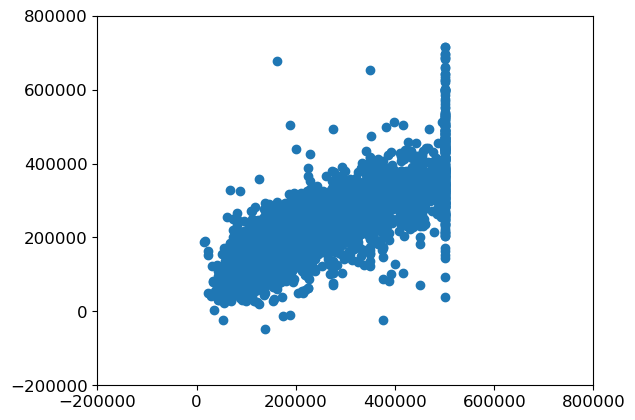

In [32]:
plt.scatter(x=y_te, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

# Save the model

In [33]:
import joblib

joblib.dump(final_model, "W4_Mandsaurwala_X585677_model.pkl")

['W4_Mandsaurwala_X585677_model.pkl']

### Question: Before you computed the final_rmse on the test data, what was your expected value for this quantity? Does your best model have high variance?

#### 1.) Since Elastic Net's RMSE is the lowest, Elastic Net is the best model. Also, I was expecting around the same RMSE on the test data.
#### 2.) Elastic Net Regression does not have high variance because Standard deviation is less (std = 1146.9809104432975).

#[Optional]
Why does the matrix X appears transponsed in the normal equation in the linear regression? Equation 4.4. Start from equation 4.3



##### Normal equation:-
##### 1/(X.TX) X.Ty
##### X appears transposed in the above equation so that matrix multiplication can be done.

#[Optional]
Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?



##### 1.) If the data is convex, then, Yes, ultimately all the Gradient Descent algorithms lead to the same model, assuming optimal hyperparamteres are selected.
##### 2.) If the data is not convex, then differenent Gradient Descent algorithms may not lead to the same model. This is because the data has multiple local minima and Gradient Descent is optimum for convex data.

#[Optional]
Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?



##### No, I don't think so that its appropriate to alwasys stop Mini-batch Gradient Descent immediately when the validation error goes up because...
##### 1.) This might be due to selection of initial high learning rate
##### 2.) Its logical to wait for few more epochs before deciding to stop

#[Optional]
Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?



##### 1.) If training error and the validation error are almost equal and fairly high it means that the model is underfitting.
##### 2.) This is a case of High bias because model is underfitting.
##### 3.) We need to reduce α because as explained in the points #1 & 2 the model is underfitting. Reducing the value of α would make model better fit to the data.

#[Optional]
Why does the matrix X appears transponsed in the normal equation in the linear regression? Equation 4.4. Start from equation 4.3



##### Normal equation:-
##### 1/(X.TX) X.Ty
##### X appears transposed in the above equation so that matrix multiplication can be done.

# [Extra] Implementing Elastic Net Regression using Pipeline

In [34]:
preprocessing = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])

preprocessing

Pipeline(steps=[('poly', PolynomialFeatures()), ('scaler', StandardScaler())])

In [35]:
# Creating the pre-processing pipeline with all the transformers
elastic_net_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('elastic_net', ElasticNet())
])

elastic_net_pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('poly', PolynomialFeatures()),
                                 ('scaler', StandardScaler())])),
                ('elastic_net', ElasticNet())])

In [36]:
# Definning all the hyperparameters
param_grid_pipeline = {
    'elastic_net__alpha': [0.1],
    'elastic_net__l1_ratio': [0.4]
}

grid_search_pipeline = GridSearchCV(elastic_net_pipeline, param_grid_pipeline, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pipeline.fit(X_tr_pipeline, y_tr)

best_en_random_grid_reg = grid_search_pipeline.best_estimator_
best_en_random_grid_reg.fit(X_tr_pipeline, y_tr)

print("Best Parameters:", grid_search_pipeline.best_params_)
print("Best RMSE:", np.sqrt(-grid_search_pipeline.best_score_))

Best Parameters: {'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.4}
Best RMSE: 79322.99627793708


In [37]:
best_en_random_grid_reg = grid_search_pipeline.best_estimator_

y_te_pip_estimation = best_en_random_grid_reg.predict(X_te_pipeline)

final_mse_pipeline = mean_squared_error(y_te, y_te_pip_estimation)
final_rmse_pipeline = np.sqrt(final_mse_pipeline)
print(final_rmse_pipeline)

66033.56995713143


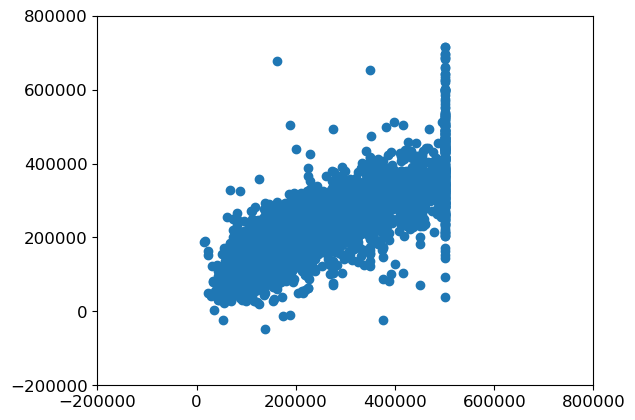

In [38]:
plt.scatter(x=y_te, y=y_te_pip_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()